In [1]:
import os
import pandas as pd
from fastbook import *
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from dtreeviz.trees import *
import sklearn

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)
     
traindf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/train.csv',low_memory=False)
testdf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/test.csv',low_memory=False)

traindf.dropna(inplace = True)

def split_names(df):
    # Create new columns for first name and last name
    df['FirstName'] = df['Name'].apply(lambda x: x.split()[0] if pd.notna(x) else pd.NA)
    df['LastName'] = df['Name'].apply(lambda x: x.split()[1] if pd.notna(x) else pd.NA)
    df.drop(columns = ['Name'],inplace = True)
    return df
traindf = split_names(traindf)
testdf = split_names(testdf)

def split_group_number(df):
    df['Group'] = df['PassengerId'].apply(lambda x: x.split("_")[0] if pd.notna(x) else pd.NA)
    df['GroupNumber'] = df['PassengerId'].apply(lambda x: x.split("_")[1] if pd.notna(x) else pd.NA)
    return df
traindf = split_group_number(traindf)
testdf = split_group_number(testdf)


/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastbook/__init__.py:11: UserWarning: Missing `ipywidgets` - please install it
  except ModuleNotFoundError: warn("Missing `ipywidgets` - please install it")
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [70]:
def family_transported(df):
    def determine_family_status(row):
        same_last_name_group = traindf[(traindf['LastName'] == row['LastName']) & (traindf.index != row.name)]
        same_last_name_group = same_last_name_group[same_last_name_group['Group'].str[-2:] == row['Group'][-2:]]
        if len(same_last_name_group) == 0:
            return 'nofam'
        elif any(same_last_name_group['Transported']):
            return 'True'
        else:
            return 'False'

    df['FamilyTransported'] = df.apply(determine_family_status, axis=1)
    return df

# Assuming traindf is your DataFrame containing information about '
traindf = family_transported(traindf)
testdf = family_transported(testdf)

In [71]:
def cabin_size(row):
    samecabin = traindf[traindf.Cabin == row.Cabin]
    return len(samecabin)

traindf['CabinSize'] = traindf.apply(cabin_size, axis = 1)
testdf['CabinSize'] = testdf.apply(cabin_size,axis = 1)

/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/pyth

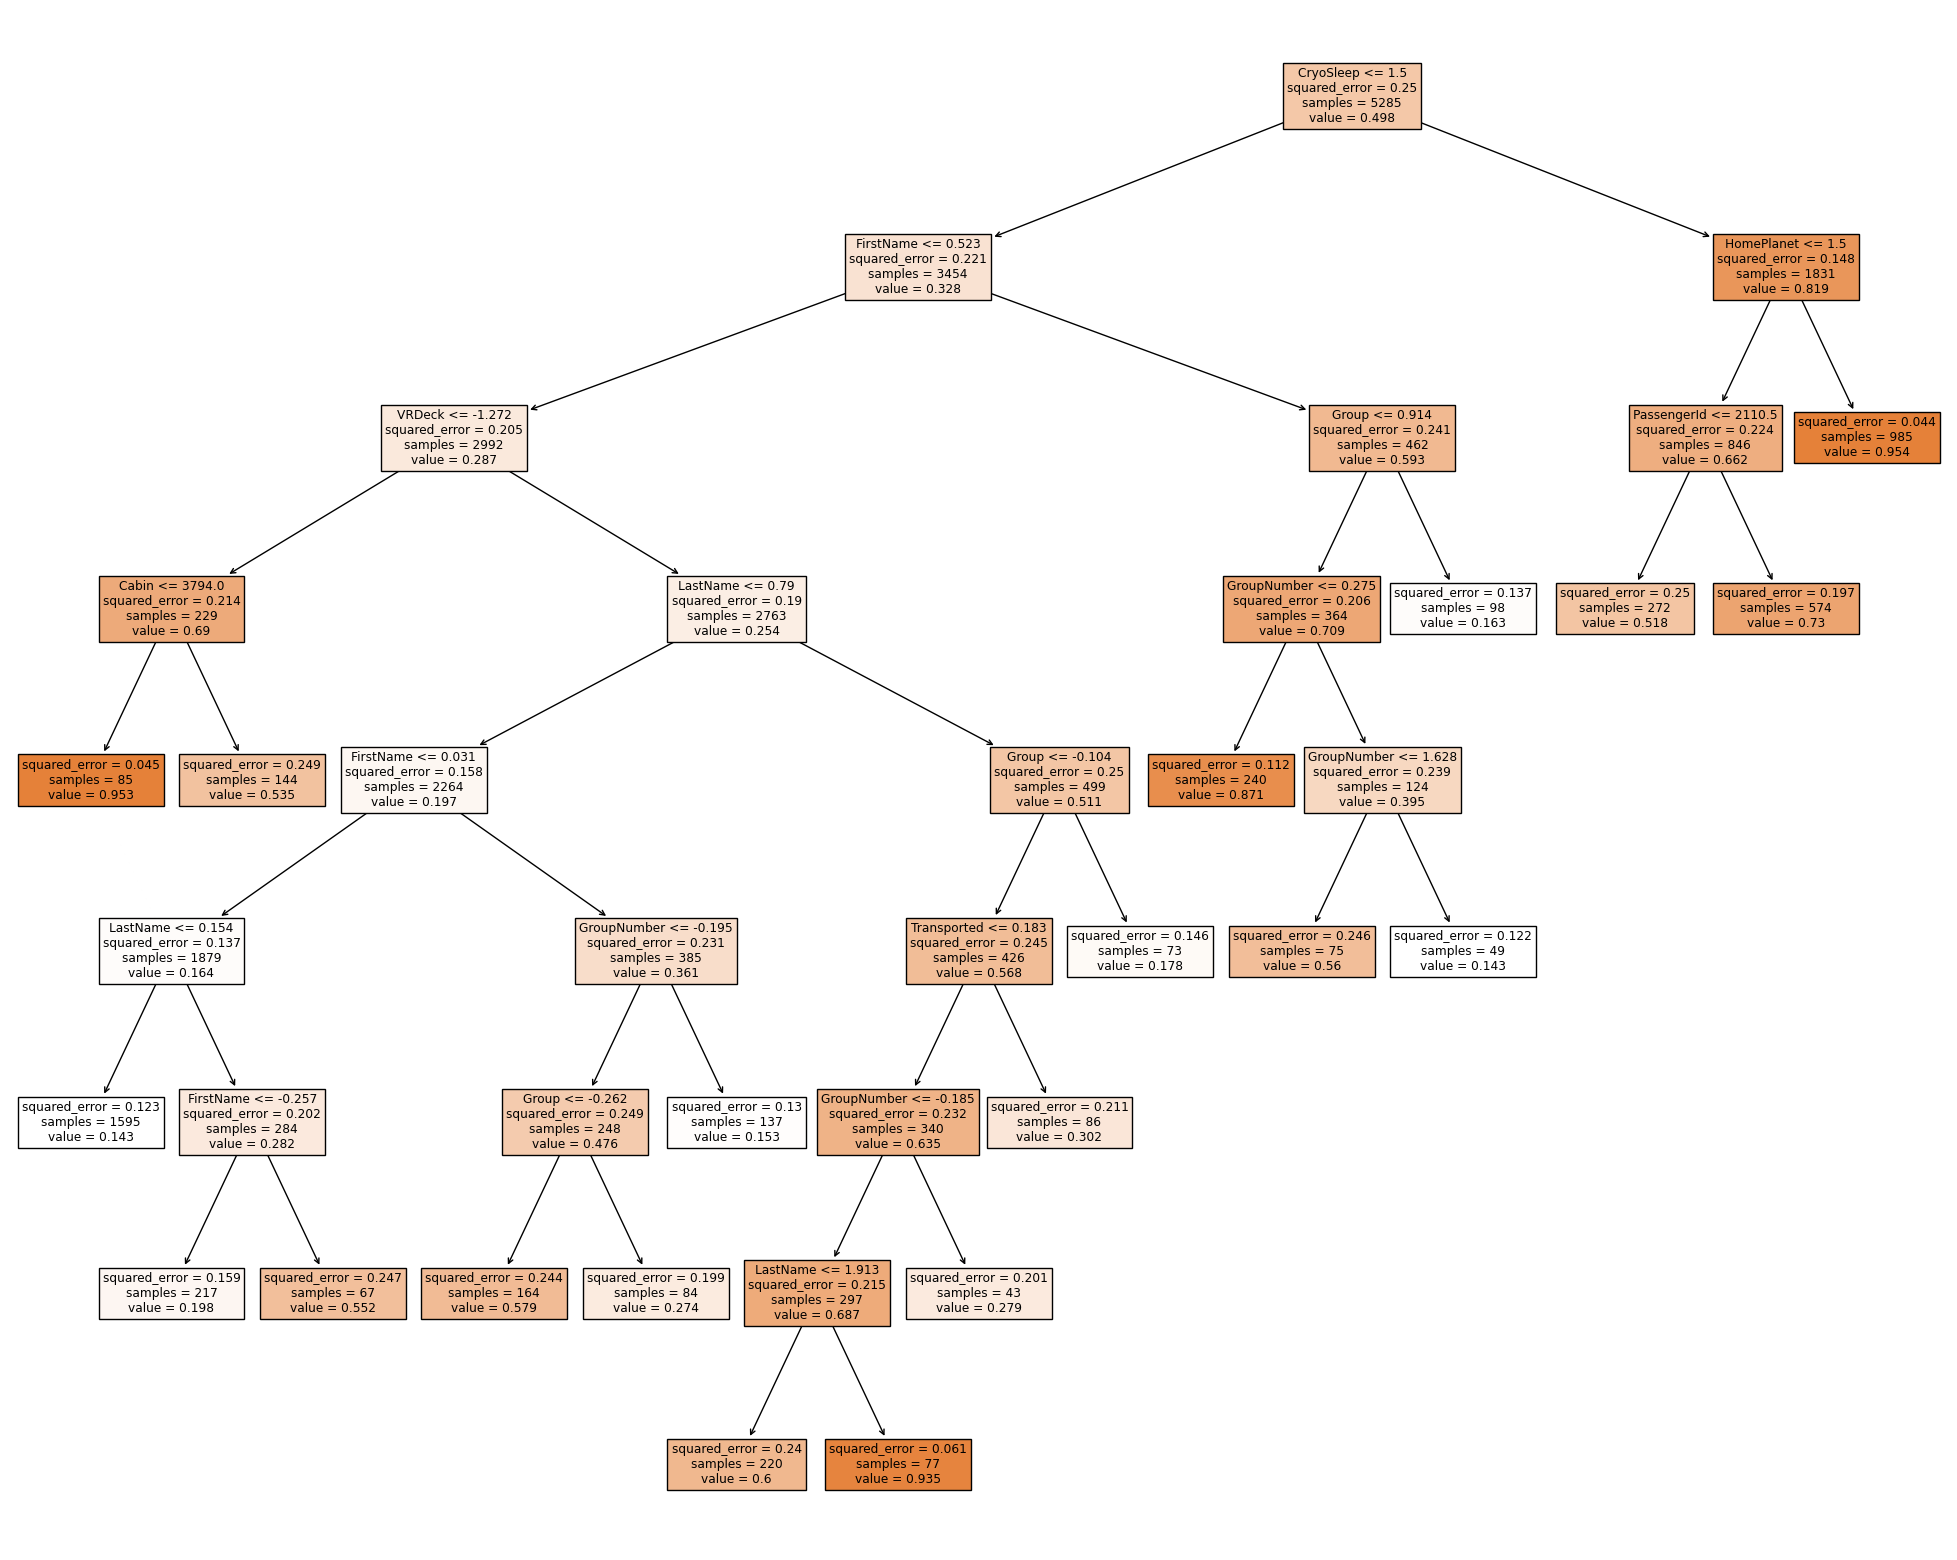

In [72]:
splits = RandomSplitter(seed = 1)(range_of(traindf))
dep_var = 'Transported'
procs = [Categorify,FillMissing,Normalize]
cont,cat = cont_cat_split(traindf, 1, dep_var=dep_var)
to = TabularPandas(traindf, procs, cat, cont, y_names=dep_var,splits = splits)



xs,y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=20)
m.fit(xs, y)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m,
                   feature_names= traindf.columns,
                   filled=True)

In [73]:
((m.predict(valid_xs) > 0.5) == valid_y).sum() / len(valid_y)


0.79333838001514

In [74]:
m = RandomForestClassifier(n_estimators= 100, max_leaf_nodes= 50)
m.fit(xs, y)
preds = m.predict(valid_xs)
print(mean_absolute_error(valid_y, preds))
(preds == valid_y).sum() /len(valid_y)


0.1975775927327782


0.8024224072672218

In [75]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
fi[:30]

,cols,imp
2,CryoSleep,0.196639
15,Spa,0.144228
12,RoomService,0.125360
16,VRDeck,0.119662
13,FoodCourt,0.094970
14,ShoppingMall,0.080218
3,Cabin,0.075807
1,HomePlanet,0.048528
11,Age,0.029464
0,PassengerId,0.017002


In [76]:
cont,cat = cont_cat_split(testdf, 1, dep_var=dep_var)
mode_values = testdf[cat].mode().iloc[0]
testdf[cat] = testdf[cat].fillna(mode_values)


for column in cont:
    mode_value = testdf[column].median()  # Calculate the mode for the column
    testdf[column].fillna(mode_value, inplace=True)  # Fill missing values with mode
    


In [77]:
testdf

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,FirstName,LastName,Group,GroupNumber,FamilyTransported,CabinSize
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly,Carsoning,0013,01,nofam,0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome,Peckers,0018,01,nofam,0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih,Unhearfus,0019,01,nofam,0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz,Caltilter,0021,01,nofam,0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence,Harperez,0023,01,nofam,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron,Peter,9266,02,nofam,0
4273,9269_01,Earth,False,G/160/P,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty,Scheron,9269,01,nofam,0
4274,9271_01,Mars,True,D/296/P,55 Cancri e,26.0,False,0.0,0.0,0.0,0.0,0.0,Jayrin,Pore,9271,01,nofam,0
4275,9273_01,Europa,False,D/297/P,TRAPPIST-1e,26.0,False,0.0,2680.0,0.0,0.0,523.0,Kitakan,Conale,9273,01,nofam,0


In [78]:
to_new = to.train.new(testdf)
to_new.process()


/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3

In [81]:


testtran = [True if x == 1 else False for x in list(m.predict(to_new.xs))]
testdf['Transported'] = testtran
ret = testdf[['PassengerId','Transported']]

ret.to_csv('submit.csv',index=False)